In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as po
import matplotlib.pyplot as plt
po.init_notebook_mode(connected=True)
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('forex.csv', parse_dates=['date']).set_index('date')
df.head()

,slug,open,high,low,close,currency
date,,,,,,
2001-04-10,GBP/EGP,5.58090,5.5947,5.5947,5.5947,EGP
2001-06-04,GBP/EGP,5.47517,5.4939,5.4939,5.4939,EGP
2001-08-01,GBP/EGP,5.67990,5.6543,5.6543,5.6543,EGP
2002-07-29,GBP/EGP,7.21700,7.2170,7.2170,7.2170,EGP
2003-01-02,GBP/EGP,7.42429,7.3899,7.3899,7.3899,EGP


In [4]:
df.isna().sum()

slug        0
open        0
high        0
low         0
close       0
currency    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1453035 entries, 2001-04-10 to 2021-08-30
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   slug      1453035 non-null  object 
 1   open      1453035 non-null  float64
 2   high      1453035 non-null  float64
 3   low       1453035 non-null  float64
 4   close     1453035 non-null  float64
 5   currency  1453035 non-null  object 
dtypes: float64(4), object(2)
memory usage: 77.6+ MB


In [6]:
import functions as fn

In [7]:
eur = fn.select('EUR')
eur.head()

The number of unique exchange (slug) is 6


,slug,open,high,low,close,currency
date,,,,,,
2004-10-25,INR/EUR,0.01710,0.01712,0.01708,0.01710,EUR
2004-10-26,INR/EUR,0.01710,0.01717,0.01706,0.01713,EUR
2004-10-27,INR/EUR,0.01713,0.01723,0.01706,0.01721,EUR
2004-10-29,INR/EUR,0.01721,0.01730,0.01715,0.01719,EUR
2004-11-01,INR/EUR,0.01715,0.01728,0.01714,0.01725,EUR


In [8]:
uniq_xchng = eur['slug'].unique()

In [9]:
df_map = eur['slug'].unique().tolist()
df_lst = [eur[eur['slug'] == x ]for x in uniq_xchng]

In [10]:
# x = 0
# for df in df_lst:
#         fig = go.Figure()
#         fig.add_trace(go.Ohlc(x=df.index, 
#                 open=df.open,
#                 high=df.high,
#                 low=df.low,
#                 close=df.close,
#                 name='Price'))
#         fig.update(layout_xaxis_rangeslider_visible=False, layout_width=1000,
#                    layout_title=df_map[x])
#         x += 1
#         fig.show()

In [11]:
# x = 0
# for df in df_lst:
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x= df.index, y=df.high, name='HIGH'))
#     fig.add_trace(go.Scatter(x= df.index, y=df.low, name='LOW'))
#     fig.update_layout(width=900, title = df_map[x])
#     fig.show()
#     x += 1

In [12]:
wkly_df_lst = [df.resample('W').mean().ffill() for df in df_lst]

In [13]:
# import statsmodels.api as sm
# from pylab import rcParams
# rcParams['figure.figsize'] = 8, 8

# x = 0
# for wkly_df in wkly_df_lst:
#     decompose_series = sm.tsa.seasonal_decompose(wkly_df['close'], model='additive')
#     decompose_series.plot()
#     print(df_map[x])
#     x += 1
#     plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_lst[2]['close'])
print(f'ADF Statistics: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used: {adf_result[3]}')
print('Critical Values')
for k,v in adf_result[4].items():
    print(f'  {k}: {v}')

ADF Statistics: -63.681206928869734
p-value: 0.0
No. of lags used: 0
No. of observations used: 4112
Critical Values
  1%: -3.4319412905876083
  5%: -2.862243144950704
  10%: -2.567144290642648


In [15]:
def stationary_check(lst):
    x = 0
    for df in lst:
        adf_result = adfuller(df['close'])
        if adf_result[1] < 0.05:
            print(f'For {df_map[x]} the series is Stationary')
        else:
            print(f'For {df_map[x]} the series is Non-Stationary')
        x += 1

In [16]:
stationary_check(df_lst)

For INR/EUR the series is Non-Stationary
For AUD/EUR the series is Non-Stationary
For JPY/EUR the series is Stationary
For CHF/EUR the series is Non-Stationary
For USD/EUR the series is Non-Stationary
For GBP/EUR the series is Non-Stationary


In [17]:
stat_df_lst = []
for df in df_lst:
    dd = df.drop(columns=['slug', 'currency'])
    adf_result = adfuller(dd['close'])
    if adf_result[1] > 0.05:
        df_log = np.log(dd)
        df_diff = df_log.diff().bfill()
        stat_df_lst.append(df_diff)
    else:
        stat_df_lst.append(dd)

In [18]:
stationary_check(stat_df_lst)

For INR/EUR the series is Stationary
For AUD/EUR the series is Stationary
For JPY/EUR the series is Stationary
For CHF/EUR the series is Stationary
For USD/EUR the series is Stationary
For GBP/EUR the series is Stationary


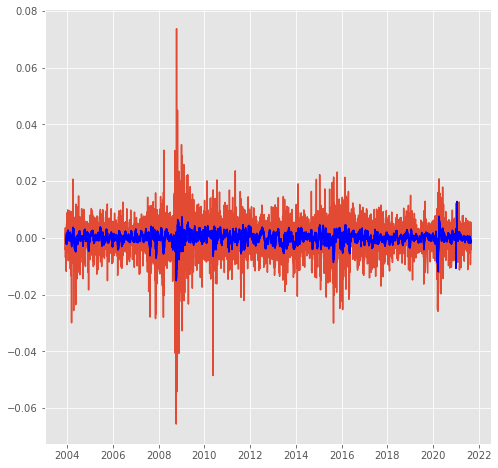

In [19]:
plt.plot(stat_df_lst[1].index, stat_df_lst[1].close, '-')
plt.plot(stat_df_lst[1].rolling(12).mean(), color='blue')
plt.show()

In [20]:
from prophet import Prophet

In [21]:
new = df_lst[0].reset_index()[['date', 'close']]
new = new.rename(columns={'date': 'ds', 'close': 'y'})
new.head()

,ds,y
0,2004-10-25,0.01710
1,2004-10-26,0.01713
2,2004-10-27,0.01721
3,2004-10-29,0.01719
4,2004-11-01,0.01725


In [22]:
train_data = new.sample(frac=0.7, random_state=2)
test_data = new.drop(train_data.index)

In [23]:
print(f'Training data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Training data shape: (2484, 2)
Test data shape: (1064, 2)


In [24]:
model = Prophet(seasonality_mode='additive', daily_seasonality=True)
model.fit(train_data)

22:13:50 - cmdstanpy - INFO - Chain [1] start processing
22:13:59 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
future = test_data[['ds']]
forecast = model.predict(future)

In [26]:
forecast.shape

(1064, 22)

In [27]:
# model.plot(forecast)
# plt.show()

In [28]:
# model.plot_components(forecast)
# plt.show()

In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def MAPE(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y)) * 100

def RMSE(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))

print(str(round(MAPE(test_data['y'], forecast['yhat']),2)) + "%")
print(RMSE(test_data['y'], forecast['yhat']))
# print('+'*10)
# print(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat'])))
# print(mean_absolute_percentage_error(test_data['y'], forecast['yhat']))

17.42%
0.0032465119113968474


In [30]:
new_mul = df_lst[0].reset_index().drop(columns=['slug', 'currency', 'open'])
new_mul = new_mul.rename(columns={'date': 'ds', 'high': 'add2', 
                                  'low': 'add3', 'close': 'y'})

In [31]:
mul_train_data = new_mul.sample(frac=0.7, random_state=2)
mul_test_data = new_mul.drop(mul_train_data.index)

In [32]:
n_model = Prophet(seasonality_mode='additive', daily_seasonality=True)
# n_model.add_regressor('add1')
n_model.add_regressor('add2')
n_model.add_regressor('add3')
n_model.fit(mul_train_data)
future = mul_test_data.drop('y', axis=1)
n_forecast = n_model.predict(future)

22:14:03 - cmdstanpy - INFO - Chain [1] start processing
22:14:07 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
print(MAPE(mul_test_data['y'], n_forecast['yhat']))
print(RMSE(mul_test_data['y'], n_forecast['yhat']))

17.409788510492785
0.0032724740498012955


In [34]:
# n_model.plot(n_forecast)
# plt.show()

In [35]:
# n_model.plot_components(n_forecast)
# plt.show()

In [50]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

diff = stat_df_lst[0][['close']]
diff = diff.resample('M').sum()
diff

# # ACF
# plot_acf(diff, lags= range(0, 20))
# plt.show()

# # PACF
# plot_pacf(diff, lags= range(0, 20),)
# plt.show()

,close
date,
2004-10-31,0.007002
2004-11-30,-0.019384
2004-12-31,0.005914
2005-01-31,0.030772
2005-02-28,-0.010345
...,...
2021-04-30,-0.042515
2021-05-31,0.017559
2021-06-30,-0.001680


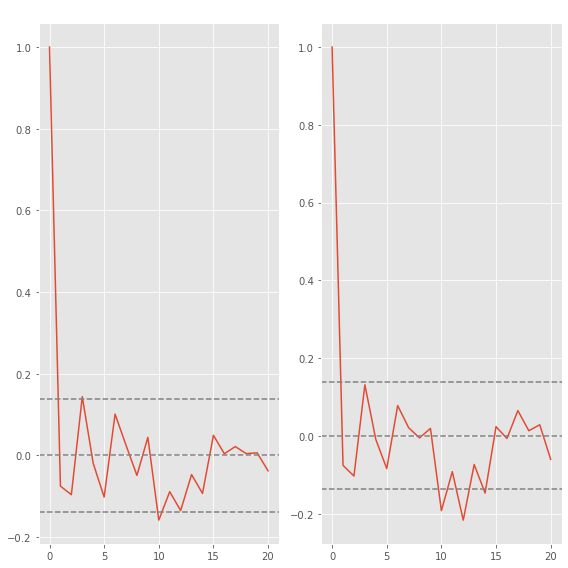

In [51]:
#ACF & PACF plots

lag_acf = acf(diff, nlags=20)
lag_pacf = pacf(diff, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 
plt.show()

RSS: 0.1218


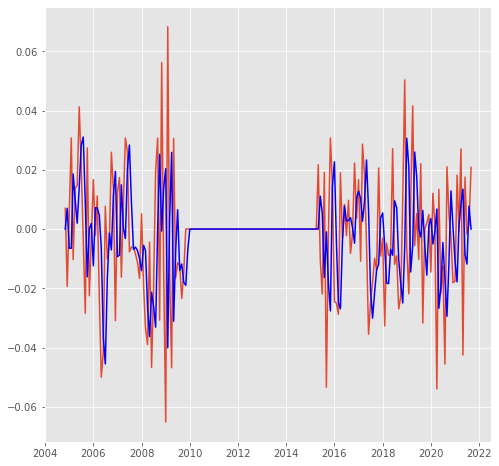

In [55]:
# AR MA and ARIMA
from statsmodels.tsa.arima.model import ARIMA
#(p,d,q)

AR_model = ARIMA(diff, order=(1,1,0))
AR_model_results = AR_model.fit()
plt.plot(diff)
plt.plot(AR_model_results.fittedvalues, color='blue')
print('RSS: %.4f'%sum((AR_model_results.fittedvalues - diff['close'])**2))
plt.show()


RSS: 0.0771


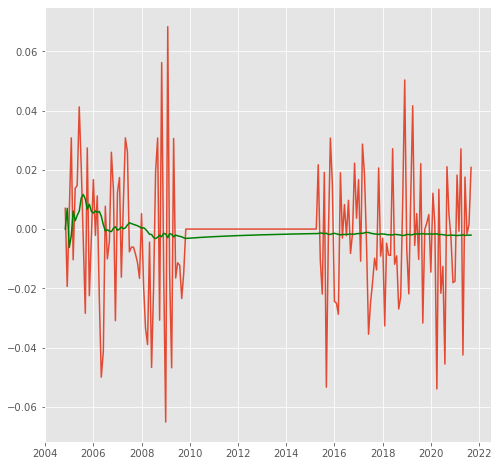

In [68]:
MA_model = ARIMA(diff, order=(0,1,1))
MA_model_results = MA_model.fit()
plt.plot(diff)
plt.plot(MA_model_results.fittedvalues, color='g')
print('RSS: %.4f'%sum((MA_model_results.fittedvalues - diff['close'])**2))
plt.show()

RSS: 0.0767


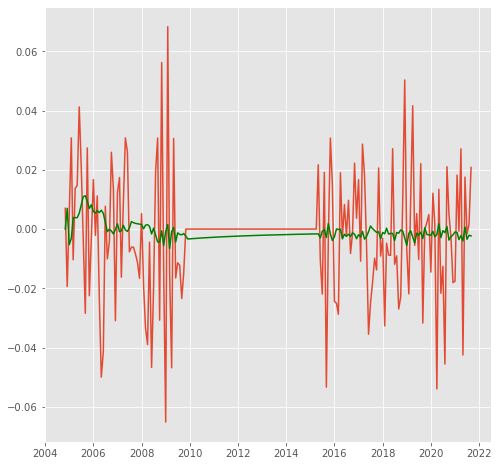

In [61]:
ARIMA_model = ARIMA(diff, order=(1,1,1))
ARIMA_results = ARIMA_model.fit()
plt.plot(diff)
plt.plot(ARIMA_results.fittedvalues, color='g')
print('RSS: %.4f'%sum((ARIMA_results.fittedvalues - diff['close'])**2))
plt.show()